# New molecule/ff input generation pipeline

In [3]:
from student.agent.tools.tools_raspa import RaspaTool
import os
import json
import requests
from student.agent.utils import *
from student.agent.tools.input_gen.pseudoatoms import PseudoAtoms, Atom
from student.agent.tools.input_gen.utils_molecules import *
from student.agent.tools.input_gen.trappe_loader import *
from student.agent.tools.tools_raspa import *

/Users/henrikseng/miniforge3/envs/student3.11/lib/python3.11/site-packages/PACMANCharge/pmcharge.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Using device: cpu


## Pseusdoatoms typing

In [3]:
import os
__file__ = os.path.join(os.getcwd(), "input_gen.ipynb")

In [4]:
t = MoleculeLoader()

In [5]:
atom_types = {}         # main_atom : {ps_type}
type_to_params = {}     # ps_type : {(params) : {name}}
param_types = {}        # ps_type : {(params)}

for name, id in t.molecules.items():
    trappe_parameters = download_parameters(id)
    pseudoatoms =t.parse_section(trappe_parameters, "#,(pseudo)atom", 6)
    for atom in pseudoatoms:
        try:
            ps_id = f"{int(atom[0])-1}"
            main_atom = atom[1]
            ps_type = atom[2]
            epsilon = float(atom[3])
            sigma = float(atom[4])
            charge = float(atom[5])
            params = (epsilon, sigma, charge)

            if main_atom not in atom_types.keys():
                atom_types[main_atom] = set()
            atom_types[main_atom].add(ps_type)
            #if main_atom == "M":
            #    print(name, ps_type)

            if ps_type not in type_to_params.keys():
                type_to_params[ps_type] = dict()
            if params not in type_to_params[ps_type]:
                type_to_params[ps_type][params] = set()
            type_to_params[ps_type][params].add(name)

            if ps_type not in param_types.keys():
                param_types[ps_type] = params       # first guess is fine, the rest is corrected below based on type_to_params
        
        except ValueError as e:
            print("Missing parameters for", name)

Missing parameters for methyl acetate
Missing parameters for ethyl acetate
Missing parameters for methyl propionate
Missing parameters for vinyl acetate


#### Type to label

In [6]:
# How many different types per main pseudoatom?
{i: len(k) for i, k in atom_types.items()}

{'CH4': 1,
 'CH3': 13,
 'CH2': 16,
 'CH': 13,
 'C': 14,
 'O': 16,
 'H': 4,
 'S': 5,
 'N': 5,
 'M': 6,
 'CF3': 1,
 'CF2': 1,
 'P': 2,
 'F': 1}

In [7]:
type_to_label = {} # main_atom : {ps_type : label/SMARTS}

for i,k in atom_types.items():
    type_to_label[i] = dict()
    for t in k:
        type_to_label[i][t] = None if len(k) != 1 else t

In [8]:
type_to_label["CH3"] = {
    '[CH3]-C#N': "CH3_cn",
    '[CH3]-S-CHx': "CH3_sc",
    '[CH3]-P': "CH3_p",
    '[CH3]-O-H': "CH3_oh",
    '[CH3]-CH=O': "CH3_co",
    '[CH3]-C-CH-O-P': "CH3_ccop",
    '[CH3]-S-S-CHx': "CH3_ssc",
    '[CH3]-SH': "CH3_sh",
    '[CH3]-CHx': "CH3_chx",
    '[CH3]-CH-O-P': "CH3_cop",
    '[CH3]-P(=O)-(OCH3)2': "CH3_po",
    '[CH3]-O-CHx': "CH3_ocg",
    '[CH3]-O-P': "CH3_op"
}

type_to_label["CH2"] = {
    '[CH2]-O-CH2': "CH2_oc",
    'O-[CH2]-CH2': "o_CH2_c",
    '[CH2]=CHx': "h2C=c",
    'CHx-[CH2]-C#N': "c_CH2cn",
    'O-[CH2]-CH2-CH2': "o_CH2_cc",
    'CHx-[CH2]-O-CHy': "c_CH2_oc",
    'CHx-[CH2]-S-S-CHx': "c_CH2_ssr",
    'CHx-[CH2]-CH=O': "c_CH2_cho",
    'CHx-[CH2]-SH': "c_CH2_sh",
    'O-[CH2]-O': "o_CH2_o",
    'CH2-[CH2]-CH2': "ch2_CH2_ch2",
    'O-CH2-[CH2]-CH2': "oc_CH2_c",
    'O-[CH2]-CH2-O': "oCH2_c_o",
    'CHx-[CH2]-CHx': "c_CH2_c",
    'CHx-[CH2]-O-H': "c_CH2_oh",
    'CHx-[CH2]-S-CHx': "c_CH2_sc"
}

type_to_label["CH"] = {

    'CHx=[CH](sp2)-CHy(sp3)': "c=CH_csp3",
    'CHx=[CH](sp2)-CHy(sp2)': "c=CH_csp2",
    
    '(CHx)2-[CH]-O-H': "r2_CH_oh",
    '(CHx)2-[CH]-CHx': "r2_CH_c",
    '(CH3)2-[CH]-O-P': "r2_CH_op",
    '(CHx)2-[CH]-SH': "r2_CH_sh",
    '(CHx)2-[CH]-O-CHy': "r2_CH_oc",
        
    'CHx-[CH]=O': "c_CH=o",
    'CH3-[CH](-C)-O-P': "me_CH(c)_op",
    
    'CH+[CH]+N': "c+CH+n",
    'CH+[CH]+S': "c+CH+s",
    'CH+[CH]+CH': "c+CH+ch",
    'N+[CH]+N': "n+CH+n"
}

type_to_label["C"] = {
    'O=[C]=O': "C_co2",
    'CHx-[C]#N': "nCr",

    'CHx=[C](sp2)-CHy(sp2)': "c=C_csp2",
    'CHx=[C](sp2)-CHy(sp3)': "c=C_csp3",

    '(CHx)3-[C]-O-H': "me3_C_oh",
    '(CHx)3-[C]-O-CHy': "me3_C_or",
    '(CHx)3-[C]-CHx': "me3_C_c",
    '(CH3)3-[C]-CH-O-P': "me3_C_cop",
    '(CHx)3-[C]-SH': "me3_C_sh",
    
    'CH+[C](-NO2)+CH': "c+C(no2)+c",
    'CH+[C](-CHx)+CH': "c+C(c)+c",
    'CH+[C](+CH)+CH': "c+C(+c)+c",

    'CHx-O-[C]=O': "roC=o",
    '[C]=O': "C=o",
}

type_to_label["O"] = {
    'CHx-[O]-CHy': "chx_O_chx",             # ether (generic)
    'CH2-[O]-CH2-O': "ch2_O_ch2_o",         # ether (double)
    'CH2-[O]-CH2-CH2': "ch2_O_ch2_ch2",     # ether (c chain)
    'CH2-[O]-CH2': "ch2_O_ch2",             # ether

    'CH=[O]': "O=ch",                       # aldehyde
    'C=[O]': "O=c",                         # carbonyl
    'CHx-O-C=[O]': "O=co",                  # carbonyl acid
    'CHx-[O]-C=O': "cO_c=o",                # ester
    'P-[O]-CH3': "pOme",                    # pOme
    'CHx-[O]-H': "hO_c",                    # alcohol
    
    'CHx-N[O]2': "Ono_c",                   # nitro
    'P-[O]-CH': "pO_ch",                    # pOr
    '[O]=P-F': "O=pf",                      # fp=O
    '[O]=P(-CH3)-(OCH3)2': "O=pco",         # O=p(c)(oc)2

    '[O]=C=O': "O_co2",                     # co2
    '[O]=O': "O_o2",                        # o2
}

type_to_label["H"] = {
    'O-[H]': "Ho",      # alcohol H
    'S-[H]': "Hs",      # thiol S
    '[H]-NH2': "H_nh3", # NH3
    '[H]-SH': "H_h2s",  # SH2
}

type_to_label["S"] = {
    'CHx-[S]-H': "hS_chx",
    'H-[S]-H': "S_h2s",
    'CHx-[S]-CHx': "chx_S_chx",
    'CHx-[S]-S-CHx': "chx_Ss_chx",
    'CH+[S]+CH': "c+S+c"
}

type_to_label["N"] = {
    'CH+[N]+CH': "c+N+c",
    '[N]-H3': "N_nh3",
    'CHx-C#[N]': "Nc_chx",
    'CHx-[N]O2': "o2N_chx",
    '[N]#N': "N_n2"
}

type_to_label["M"] = {
    '[M]pi': "M_pi",
    '[M]center': "M_center",
    'H2S-[M]': "M_h2s",
    '[M]-NH3': "M_nh3",
    'O=[M]=O': "M_o2",
    'N#[M]#N': "M_n2"
}

type_to_label["P"] = {
    'F-[P](=O)-O-CH': "fPoome",
    'CH3-[P](=O)-(OCH3)2': "mePoome"
}

In [9]:
# Check for duplicate labels
labels = [label for ps_type in type_to_label.values() for label in ps_type.values()]
print("Unique labels: ", len(labels) == len(set(labels)))

from collections import Counter
duplicates = [item for item, count in Counter(labels).items() if count > 1]
if len(duplicates) > 0:
    print("Not unique: ", duplicates)

Unique labels:  True


### Type to smarts

In [10]:
type_to_smarts = {} # main_atom : {ps_type : label/SMARTS}

for i,k in atom_types.items():
    type_to_smarts[i] = dict()
    for t in k:
        type_to_smarts[i][t] = None

In [11]:
type_to_smarts["CH4"] = {"CH4": "[CH4]"}
type_to_smarts["CF3"] = {"[CF3]-CFx": "[C](F)(F)F-[C;X4]"}
type_to_smarts["CF2"] = {"CFx-[CF2]-CFx": "[C;X4]-[C;X4](F)(F)-[C;X4]"}
type_to_smarts["F"] = {"P-[F]": "[P]-[F]" }

type_to_smarts["CH3"] = {
    '[CH3]-C#N': '[CH3][C]#N',
    '[CH3]-S-CHx': '[CH3][S][C]',
    '[CH3]-P': '[CH3][P]',
    '[CH3]-O-H': '[CH3][O][H]',
    '[CH3]-CH=O': '[CH3][CH]=O',
    '[CH3]-C-CH-O-P': '[CH3][C]([CH])[O][P]',
    '[CH3]-S-S-CHx': '[CH3][S][S][C]',
    '[CH3]-SH': '[CH3][S][H]',
    '[CH3]-CHx': '[CH3][C]',
    '[CH3]-CH-O-P': '[CH3][CH][O][P]',
    '[CH3]-P(=O)-(OCH3)2': '[CH3][P](=O)(OC)(OC)',
    '[CH3]-O-CHx': '[CH3][O][C]',
    '[CH3]-O-P': '[CH3][O][P]'
}

type_to_smarts["CH2"] = {
    'CH2-O-[CH2]-O-CH2' : "[CH2][O][CH2][O][CH2]",
    'O-[CH2]-O': '[O][CH2][O]',
    
    '[CH2]-O-CH2': '[CH2][O][CH2]',
    'O-[CH2]-CH2': '[O][CH2][CH2]',
    'O-[CH2]-CH2-CH2': '[O][CH2][CH2][CH2]',
    'CHx-[CH2]-O-CHy': '[C][CH2][O][C;H1+]',
    
    'O-[CH2]-CH2-O': '[O][CH2][CH2][O]',
    'CHx-[CH2]-O-H': '[C][CH2][O][H]',

    'O-[CH2]-CH2-O' : "[O][CH2][CH2][O]",

    'O-[CH2]-CH2 r5' : "[O;r5][CH2;r5][CH2;r5]",
    'O-[CH2]-CH2 r6' : "[O;r6][CH2;r6][CH2;r6]",
    #del x['O-[CH2]-CH2']

    '[CH2]=CHx': '[CH2]=[C]',
    'CHx-[CH2]-C#N': '[C][CH2][C]#N',
    
    'CHx-[CH2]-S-S-CHx': '[C][CH2][S][S][C]',
    'CHx-[CH2]-S-CHx': '[C][CH2][S][C]',
    'CHx-[CH2]-SH': '[C][CH2][S][H]',

    'CHx-[CH2]-CH=O': '[C][CH2][CH]=O',
    #'O-CH2-[CH2]-CH2': '[O][CH2][CH2][CH2]',
    'O-CH2-[CH2]-CH2 r6' : "[O;r6][CH2;r6][CH2;r6][CH2;r6]",
    'O-CH2-[CH2]-CH2 r5' : "[O;r5][CH2;r5][CH2;r5][CH2;r5]",

    'CH2-[CH2]-CH2 r8+' : "[CH2;r7+][CH2;r7+][CH2;r7+]",
    'CH2-[CH2]-CH2 r6' : "[CH2;r6][CH2;r6][CH2;r6]",
    'CH2-[CH2]-CH2 r5' : "[CH2;r5][CH2;r5][CH2;r5]",

    #'CH2-[CH2]-CH2': '[CH2][CH2][CH2]',
    'CHx-[CH2]-CHx': '[C][CH2][C]',
}

type_to_smarts["CH"] = {
    'CHx=[CH](sp2)-CHy(sp3)': '[C]=[CH][C;X4]',
    'CHx=[CH](sp2)-CHy(sp2)': '[C]=[CH][C;X3]',
    
    '(CHx)2-[CH]-O-H': '[C][CH]([C])[O][H]',
    '(CH3)2-[CH]-O-P': '[CH3][CH]([CH3])[O][P]',
    '(CHx)2-[CH]-SH': '[C][CH]([C])[S][H]',
    '(CHx)2-[CH]-O-CHy': '[C][CH]([C])[O][C;H1+]',
    '(CHx)2-[CH]-CHx': '[C][CH]([C])[C]',
    
    'CHx-[CH]=O': '[C][CH]=O',
    'CH3-[CH](-C)-O-P': '[CH3][CH]([C])[O][P]',

    'CH+[CH]+N': '[c]:[c]:[n]',
    'CH+[CH]+S': '[c]:[c]:[s]',
    'CH+[CH]+CH': '[c]:[c]:[c]',
    'N+[CH]+N': '[n]:[c]:[n]'
}

type_to_smarts["C"] = {
    'O=[C]=O': 'O=[C]=O',
    'CHx-[C]#N': '[C][C]#N',

    'CHx=[C](sp2)-CHy(sp2)': '[C]=[C]([C;X3])',
    'CHx=[C](sp2)-CHy(sp3)': '[C]=[C]([C;X4])',

    '(CHx)3-[C]-O-H': '[C][C]([C])([C])[O][H]',
    '(CHx)3-[C]-O-CHy': '[C][C]([C])([C])[O][C;H1+]',
    '(CHx)3-[C]-CHx': '[C][C]([C])([C])[C]',
    '(CH3)3-[C]-CH-O-P': '[CH3][C]([CH3])([CH3])[CH][O][P]',
    '(CHx)3-[C]-SH': '[C][C]([C])([C])[S][H]',

    'CHx-O-[C]=O': '[C][O][C]=O',
    '[C]=O': '[C]=O',

    'CH+[C](-NO2)+CH': '[c]:[c]([N](O)[O]):[c]',
    'CH+[C](-CHx)+CH': '[c]:[c]([C]):[c]',
    'CH+[C](+CH)+CH': '[c]:[c]([c]):[c]',

}

type_to_smarts["O"] = {
    
    #'CH2-[O]-CH2-O': '[CH2][O][CH2][O]', #del x['CH2-[O]-CH2-O']
    'CH2-[O]-CH2-CH2': '[CH2][O][CH2][CH2]',
    #'CH2-[O]-CH2': '[CH2][O][CH2]', #del x['CH2-[O]-CH2']
    'O-CH2-[O]-CH2-O' : "[O][CH2][O][CH2][O]",

    'CH2-[O]-CH2-O r5': "[CH2;r5][O;r5][CH2;r5][O]",
    'CH2-[O]-CH2-O r6': "[CH2;r6][O;r6][CH2;r6][O]",
    
    'CH2-[O]-CH2 r5' :"[CH2;r5][O;r5][CH2;r5]",
    'CH2-[O]-CH2 r6' : "[CH2;r6][O;r6][CH2;r6]",
    'CH2-[O]-CH2 r3' : "[CH2;r3][O;r3][CH2;r3]",

    'CHx-O-C=[O]': '[C][O][C]=O',
    'CHx-[O]-C=O': '[C][O][C]=O',
    'P-[O]-CH3': '[P][O][CH3]',
    
    'P-[O]-CH': '[P][O][CH]',
    '[O]=P-F': 'O=P(F)',
    '[O]=P(-CH3)-(OCH3)2': 'O=P([CH3])(OC)(OC)',
    '[O]=C=O': 'O=C=O',
    '[O]=O': 'O=O',
    
    'CHx-N[O]2': '[C][N](O)[O]',
    'CHx-[O]-H': '[C][O][H]',
    'CHx-[O]-CHy': '[C][O][C]',
    'CH=[O]': '[CH]=O',
    'C=[O]': '[C]=O',
}

type_to_smarts["H"] = {
    '[H]-SH': '[H][S][H]',
    '[H]-NH2': '[H][N]([H])[H]',
    'O-[H]': '[O][H]',
    'S-[H]': '[S][H]',
}

type_to_smarts["S"] = {
    'CHx-[S]-H': '[C][S][H]',
    'H-[S]-H': '[H][S][H]',
    'CHx-[S]-CHx': '[C][S][C]',
    'CHx-[S]-S-CHx': '[C][S][S][C]',
    'CH+[S]+CH': '[c]:[s]:[c]'
}

type_to_smarts["N"] = {
    'CH+[N]+CH': '[c]:[n]:[c]',
    '[N]-H3': '[N]([H])([H])[H]',
    'CHx-C#[N]': '[C][C]#N',
    'CHx-[N]O2': '[C][N](O)[O]',
    '[N]#N': '[N]#[N]'
}

type_to_smarts["M"] = {
    '[M]pi': '[M]_pi',
    '[M]center': '[M]_center',
    'H2S-[M]': '[S]([H])[H][M]',
    '[M]-NH3': '[M][N]([H])([H])[H]',
    'O=[M]=O': 'O=[M]=O',
    'N#[M]#N': 'N#[M]#N'
}

type_to_smarts["P"] = {
    'F-[P](=O)-O-CH': '[F][P](=O)([O][CH])',
    'CH3-[P](=O)-(OCH3)2': '[CH3][P](=O)(OC)(OC)'
}

### Type to parameters

In [12]:
# Almost all ps_types have unique parameters, except for these:
{k: v for k, v in type_to_params.items() if len(v) != 1}

{'CH2-[CH2]-CH2': {(56.3, 3.88, 0.0): {'cyclopentane'},
  (52.5, 3.91, 0.0): {'cyclohexane', 'oxane'},
  (51.0, 3.89, 0.0): {'cyclododecane', 'cyclooctadecane', 'cyclooctane'}},
 'CH2-[O]-CH2': {(155.0, 2.39, -0.36): {'1,3,5-trioxane'},
  (190.0, 2.2, -0.41): {'tetrahydrofuran'},
  (155.0, 2.39, -0.44): {'oxane'},
  (29.0, 3.1, -0.42): {'ethylene oxide'}},
 'O-[CH2]-O': {(52.5, 3.91, 0.36): {'1,3,5-trioxane', '1,3-dioxane'},
  (56.3, 3.88, 0.36): {'1,3-dioxolane'}},
 'CH2-[O]-CH2-O': {(190.0, 2.2, -0.425): {'1,3-dioxolane'},
  (155.0, 2.39, -0.395): {'1,3-dioxane'}},
 'O-[CH2]-CH2': {(56.3, 3.88, 0.245): {'1,3-dioxolane'},
  (56.3, 3.88, 0.16): {'tetrahydrofuran'},
  (52.5, 3.91, 0.17): {'oxane'}},
 'O-CH2-[CH2]-CH2': {(52.5, 3.91, 0.05): {'1,3-dioxane', 'oxane'},
  (56.3, 3.88, 0.045): {'tetrahydrofuran'}},
 'CH+[CH]+CH': {(48.0, 3.74, 0.0): {'benzene (9 site)',
   'nitrobenzene',
   'pyridine',
   'pyrimidine',
   'toluene (10 site)'},
  (50.5, 3.695, 0.0): {'benzene (6 site)',
   'e

### Manual corrections

In [144]:
corrected_types = [
    'CH2-[CH2]-CH2 r5',
    'CH2-[CH2]-CH2 r6',
    'CH2-[CH2]-CH2 r8+',

    'CH2-[O]-CH2 r5',
    'CH2-[O]-CH2 r6',
    'CH2-[O]-CH2 r3',

    'O-[CH2]-O',

    'CH2-[O]-CH2-O r5',
    'CH2-[O]-CH2-O r6',

    'O-[CH2]-CH2 r5',
    'O-[CH2]-CH2 r6',

    'O-CH2-[CH2]-CH2 r6',
    'O-CH2-[CH2]-CH2 r5',

    'O-CH2-[O]-CH2-O',
    'CH2-O-[CH2]-O-CH2',
    'O-[CH2]-CH2-O',
]

In [145]:
# exclude aromatics with pi system:  {'benzene (9 site)', 'nitrobenzene', 'pyridine', 'pyrimidine', 'toluene (10 site)'}

# include ring size for the others:
param_corrections = {
    'CH+[CH]+CH' : (50.5, 3.695, 0.0),

    'CH2-[CH2]-CH2 r5': (56.3, 3.88, 0.0),
    'CH2-[CH2]-CH2 r6': (52.5, 3.91, 0.0),
    'CH2-[CH2]-CH2 r8+': (51.0, 3.89, 0.0), # or greater!

    'CH2-[O]-CH2 r5': (190.0, 2.2, -0.41),
    'CH2-[O]-CH2 r6': (155.0, 2.39, -0.44),    # 
    'CH2-[O]-CH2 r3': (29.0, 3.1, -0.42),
 
    'O-[CH2]-O': (56.3, 3.88, 0.36),
 
    'CH2-[O]-CH2-O r5': (190.0, 2.2, -0.425),
    'CH2-[O]-CH2-O r6': (155.0, 2.39, -0.395),
 
    'O-[CH2]-CH2 r5': (56.3, 3.88, 0.16),
    'O-[CH2]-CH2 r6': (52.5, 3.91, 0.17),
 
    'O-CH2-[CH2]-CH2 r6' : (52.5, 3.91, 0.05),
    'O-CH2-[CH2]-CH2 r5' : (56.3, 3.88, 0.045),
    
    'O-CH2-[O]-CH2-O' : (155.0, 2.39, -0.36),    # 1,3,5-trioxane
    'CH2-O-[CH2]-O-CH2' : (52.5, 3.91, 0.36),    # {'1,3,5-trioxane', '1,3-dioxane'},
    'O-[CH2]-CH2-O' : (56.3, 3.88, 0.245),       # {'1,3-dioxolane'},
}

for ps_type, params in param_corrections.items():
    param_types[ps_type] = params

# deletes = ['CH2-[CH2]-CH2', 'CH2-[O]-CH2']
print("Parameters corrected!")

Parameters corrected!


In [185]:
def correct_label(main_atom, label, name):
    if main_atom == "CH2":
        if label == "CH2-[CH2]-CH2":
            if name == "cyclopentane":
                return 'CH2-[CH2]-CH2 r5'
            if name == "cyclohexane":
                return 'CH2-[CH2]-CH2 r6'
            if name in ['cyclododecane', 'cyclooctadecane', 'cyclooctane']:
                return 'CH2-[CH2]-CH2 r8+'
        
        if name == '1,3-dioxolane':
            if label == "CH2-[CH2]-CH2":
                return "CH2-[CH2]-CH2 r6"
            if label == 'O-[CH2]-CH2':
                return "O-[CH2]-CH2-O"
            if label == 'O-[CH2]-O':
                return 'CH2-O-[CH2]-O-CH2'    
        if name == '1,3,5-trioxane':
            return 'CH2-O-[CH2]-O-CH2'

        if name == "tetrahydrofuran":
            if label == 'O-[CH2]-CH2':
                return 'O-[CH2]-CH2 r5'
            if label == 'O-CH2-[CH2]-CH2':
                return 'O-CH2-[CH2]-CH2 r5'
        if name == "oxane":
            if label == 'O-[CH2]-CH2':
                return 'O-[CH2]-CH2 r6'
            if label == 'O-CH2-[CH2]-CH2':
                return 'O-CH2-[CH2]-CH2 r6'
        
        if name == "1,3-dioxane":
            if label == 'O-[CH2]-O':
                return 'CH2-O-[CH2]-O-CH2'
            if label == 'O-CH2-[CH2]-CH2':
                return 'O-CH2-[CH2]-CH2 r6'
        if name == "oxane":
            if label == 'O-[CH2]-CH2':
                return 'O-[CH2]-CH2 r6'
            if label == 'CH2-[CH2]-CH2':
                return 'CH2-[CH2]-CH2 r6'
            if label == "O-CH2-[CH2]-CH2":
                return "O-CH2-[CH2]-CH2 r6"

    if main_atom == "O":
        if label == 'CH2-[O]-CH2':
            if name == '1,3,5-trioxane':
                return 'O-CH2-[O]-CH2-O'
            if name == "tetrahydrofuran":
                return 'CH2-[O]-CH2 r5'
            if name == "oxane":
                return 'CH2-[O]-CH2 r6'
            if name == "ethylene oxide":
                return 'CH2-[O]-CH2 r3'

        if label == 'CH2-[O]-CH2-O': 
            if name == '1,3-dioxolane':
                return 'CH2-[O]-CH2-O r5'
            if name == '1,3-dioxane':
                return 'CH2-[O]-CH2-O r6'
    return label
correct_label("CH2", "CH2-[CH2]-CH2", "oxane")

'CH2-[CH2]-CH2 r6'

##### Adapt labels

In [173]:
x = type_to_label["CH2"]
x['CH2-[CH2]-CH2 r5']= "ch2_CH2_ch2"
x['CH2-[CH2]-CH2 r6']= "ch2_CH2_ch2"
x['CH2-[CH2]-CH2 r8+']= "ch2_CH2_ch2"
x['O-[CH2]-CH2 r5']= "o_CH2_c"
x['O-[CH2]-CH2 r6']= "o_CH2_c"
x['O-CH2-[CH2]-CH2 r6']= "oc_CH2_c"
x['O-CH2-[CH2]-CH2 r5']= "oc_CH2_c"
x['O-[CH2]-O']= "o_CH2_o"
x['CH2-O-[CH2]-O-CH2']= "co_CH2_oc"
x['O-[CH2]-CH2-O']= "o_CH2_co"

x = type_to_label["O"]
x['CH2-[O]-CH2 r5']= "ch2_O_ch2"
x['CH2-[O]-CH2 r6'] = "ch2_O_ch2"
x['CH2-[O]-CH2 r3'] = "ch2_O_ch2"
x['CH2-[O]-CH2-O r5']= "ch2_O_ch2o"
x['CH2-[O]-CH2-O r6']= "ch2_O_ch2o"
x['O-CH2-[O]-CH2-O']= "och2_O_ch2o"

##### Adapt SMARTS

In [ ]:
'''
x = type_to_smarts["CH2"]
x['CH2-[CH2]-CH2 r5']= "[CH2;r5][CH2;r5][CH2;r5]"
x['CH2-[CH2]-CH2 r6']= "[CH2;r6][CH2;r6][CH2;r6]"
x['CH2-[CH2]-CH2 r8+']= "[CH2;r7+][CH2;r7+][CH2;r7+]"
del x['CH2-[CH2]-CH2']

x['O-[CH2]-CH2 r5']= "[O;r5][CH2;r5][CH2;r5]"
x['O-[CH2]-CH2 r6']= "[O;r6][CH2;r6][CH2;r6]"
del x['O-[CH2]-CH2']

x['O-CH2-[CH2]-CH2 r6']= "[O;r6][CH2;r6][CH2;r6][CH2;r6]"
x['O-CH2-[CH2]-CH2 r5']= "[O;r5][CH2;r5][CH2;r5][CH2;r5]"
del x['O-CH2-[CH2]-CH2']

x['O-[CH2]-O']= '[O][CH2][O]'
x['CH2-O-[CH2]-O-CH2']= "[CH2][O][CH2][O][CH2]"
x['O-[CH2]-CH2-O']= "[O][CH2][CH2][O]"

x = type_to_smarts["O"]
x['CH2-[O]-CH2-O r5']= "[CH2;r5][O;r5][CH2;r5][O]"
x['CH2-[O]-CH2-O r6']= "[CH2;r6][O;r6][CH2;r6][O]"
del x['CH2-[O]-CH2-O']

x['CH2-[O]-CH2 r5']= "[CH2;r5][O;r5][CH2;r5]"
x['CH2-[O]-CH2 r6'] = "[CH2;r6][O;r6][CH2;r6]"
x['CH2-[O]-CH2 r3'] = "[CH2;r3][O;r3][CH2;r3]"
del x['CH2-[O]-CH2']

x['O-CH2-[O]-CH2-O']= "[O][CH2][O][CH2][O]"
'''

In [ ]:
import pickle

with open("parameters/ps_type_to_label.pkl", "wb") as f:
    pickle.dump(type_to_label, f)

with open("parameters/ps_type_to_smarts.pkl", "wb") as f:
    pickle.dump(type_to_smarts, f)

with open("parameters/param_types.pkl", "wb") as f:
    pickle.dump(param_types, f)



In [4]:
import pickle
with open("parameters/ps_type_to_label.pkl", "rb") as f:
    type_to_label = pickle.load(f)

with open("parameters/ps_type_to_smarts.pkl", "rb") as f:
    type_to_smarts = pickle.load(f)

with open("parameters/param_types.pkl", "rb") as f:
    param_types = pickle.load(f)

## Load critical properties

In [177]:
import pandas as pd

In [119]:
data = pd.read_csv("properties/critprop_data_only_smiles_mean_value_expt.csv", usecols=[0,1,2,4])
print(data.columns)
data

Index(['smiles', 'Tc (K)', 'Pc (bar)', 'omega (-)'], dtype='object')


,smiles,Tc (K),Pc (bar),omega (-)
0,C,190.56,45.97,0.011
1,CC,305.35,48.71,0.099
2,CCC,369.82,42.39,0.151
3,CCCC,425.15,37.90,0.199
4,CCCCC,469.69,33.67,0.252
...,...,...,...,...
5675,CCCCCOC(=O)C1=CC=CC=C1,736.00,21.90,NaN
5676,CCCCCCOC(=O)C1=CC=CC=C1,748.00,19.80,NaN
5677,C(=C/F)\C(F)(F)F,382.40,36.40,NaN
5678,C(=C\F)\C(F)(F)F,423.30,35.33,NaN


In [120]:
all_smiles = data["smiles"]
print(len(all_smiles))
query = "CCCO"
x = data[data["smiles"] == query]
x

5680


,smiles,Tc (K),Pc (bar),omega (-)
76,CCCO,536.78,51.48,0.621


In [121]:
x.to_dict('records')[0].keys()

dict_keys(['smiles', 'Tc (K)', 'Pc (bar)', 'omega (-)'])

#### Check if the smiles are the pubchem smiles

In [122]:
fails = 0
f = {}
success = 0
exceptions = {}

for s in all_smiles[600:700]:
    try:
        id = smiles_to_pubchem_id(s, same_isotope=False)
        smiles_pubchem = pubchem_id_to_property(id[0], "SMILES")
        if s in smiles_pubchem:
            success +=1
        else:
            fails += 1
            f[s] = smiles_pubchem
    except Exception as e:
        exceptions[s] = e

In [123]:
print(fails, success)

4 96


In [124]:
print(f)    # other canonicalization!

{'C=C/C(C)=C/C': ['C/C=C(\\C)/C=C'], 'C/C=C/CC(C)=O': ['C/C=C/CC(=O)C'], 'C/C=C(/C=O)CC': ['CC/C(=C\\C)/C=O'], 'C/C=C/C(=O)OCC': ['CCOC(=O)/C=C/C']}


In [125]:
id = smiles_to_pubchem_id('C/C=C/CC(C)=O', same_isotope=False)
smiles_pubchem = pubchem_id_to_property(id[0], "SMILES")
smiles_pubchem

['C/C=C/CC(=O)C']

#### Update SMILES to PubChem compatible SMILES

In [126]:
def smiles_to_pubchem_smiles(smiles):
    try:
        id = smiles_to_pubchem_id(s, same_isotope=False)
        smiles_pubchem = pubchem_id_to_property(id[0], "SMILES")
        if s in smiles_pubchem:
            return smiles
        else:
            print(smiles," -> ", smiles_pubchem)
            return smiles_pubchem
    except Exception as e:
        return smiles

# data['smiles'] = data['smiles'].apply(smiles_to_pubchem_smiles)   # ~ 60 min

### Interface

In [ ]:
# load data only if required, store for next time
def get_properties(smiles):
    properties = data[data["smiles"] == smiles]
    return properties.to_dict('records')[0]         # keys = ['smiles', 'Tc (K)', 'Pc (bar)', 'omega (-)']
from rdkit import Chem
from rdkit.Chem import Atom

print("Main atom types: ", list(type_to_smarts.keys()))

# Bonded interactions

In [14]:
t = MoleculeLoader()

### Check for uniquness:

In [15]:
stretch_labels = {}   # label : {force constants}
bend_labels = {}
torsion_labels = {}

for name, id in t.molecules.items():
    trappe_parameters = download_parameters(id)
    
    stretches =t.parse_section(trappe_parameters, "#,stretch", 4)
    bond_stretches = []
    bonds = []
    for bond in stretches:
        _, bond_range, bond_type, length_str = bond
        if bond_type not in stretch_labels.keys():
            stretch_labels[bond_type] = set()
        stretch_labels[bond_type].add(length_str)

        #if bond_type == "CH2-O":
        #    print(name, length_str)
   
    bends =t.parse_section(trappe_parameters, "#,bend", 5)
    bond_bends = []
    for bend in bends:
        _, bend_range, bend_type, theta_str, k_theta_str = bend
        if bend_type not in bend_labels.keys():
            bend_labels[bend_type] = set()
        bend_labels[bend_type].add((theta_str, k_theta_str))
        
    torsions =t.parse_section(trappe_parameters, "#,torsion", 7)
    bond_torsions = []
    for torsion in torsions:
        _, torsion_range, torsion_type, c0_str, c1_str, c2_str, c3_str = torsion
        if torsion_type not in torsion_labels.keys():
            torsion_labels[torsion_type] = set()
        torsion_labels[torsion_type].add((c0_str, c1_str, c2_str, c3_str))

In [16]:
{i:j for i,j in stretch_labels.items() if len(j) > 1} 
# unique stretch lenght except for 'CH2-O': {'1.41', '1.431'}
# 1.431 is for ethylene oxide (epoxide)!

{'CH2-O': {'1.41', '1.431'}}

In [17]:
{i:j for i,j in bend_labels.items() if len(j) > 1} # unique stretch lenght except for 'CH2-O': {'1.41', '1.431'},

{}

In [18]:
{i:j for i,j in torsion_labels.items() if len(j) > 1}

{}

## Generate useful datastructures with information on bonded interactions

In [260]:
stretch_labels = {}   # label : force constant
stretches_atoms = {}   # tuple(atom1, atom2) : label
stretches_atoms_bonds = {}  #atom1 : {atom2 : label}        => two directions

bend_labels = {}       # label : params
bend_atoms = {}        # atom_center : {atom_left :{atom_right : label}}    => two directions

torsion_labels = {}
torsion_atoms = {}     # a1 : {a2 : {a3: {a4 : label}}}         => two directions

for name, id in t.molecules.items():
    trappe_parameters = download_parameters(id) 

    id_ps = {}   

    if name in ["methyl acetate", "ethyl acetate", "methyl propionate", "vinyl acetate"]:
        print("No data available for ", name)
        continue
    
    try:
        pseudoatoms =t.parse_section(trappe_parameters, "#,(pseudo)atom", 6)
        for atom in pseudoatoms:
            
            ps_id = int(atom[0])-1
            main_atom = atom[1]
            ps_type = atom[2]
            epsilon = float(atom[3])
            sigma = float(atom[4])
            charge = float(atom[5])
            
            ps_type = correct_label(main_atom, ps_type, name)
            if ps_type == "CH2-[CH2]-CH2":
                print(name, atom)
            
            id_ps[ps_id] = ps_type

            if main_atom not in atom_types.keys():
                atom_types[main_atom] = set()
            atom_types[main_atom].add(ps_type)
            #if main_atom == "M":
            #    print(name, ps_type)

        stretches =t.parse_section(trappe_parameters, "#,stretch", 4)
        bond_stretches = []
        bonds = []
        for bond in stretches:
            if bond == ['', '"\' - \'"', '', '']:
                continue

            _, bond_range, bond_type, length_str = bond
            if bond_type not in stretch_labels.keys():
                stretch_labels[bond_type] = set()
            stretch_labels[bond_type].add(length_str)

            #if bond_type == "CH2-O":
            #    print(name, length_str)

            
            bond_range = bond_range.strip(' "\'')
            parts = [p.strip(' "\'') for p in bond_range.split('-')]
            try:
                atom1 = int(parts[0]) - 1  # Convert from 1-indexed to 0-indexed.
                atom2 = int(parts[1]) - 1
                eq_length = float(length_str)

                ps1 = id_ps[atom1]
                ps2 = id_ps[atom2]

                stretches_atoms[(ps1, ps2)] = bond_type

                if ps1 not in stretches_atoms_bonds.keys():
                    stretches_atoms_bonds[ps1] = dict()
                
                if ps2 not in stretches_atoms_bonds.keys():
                    stretches_atoms_bonds[ps2] = dict()

                stretches_atoms_bonds[ps1][ps2] = bond_type
                stretches_atoms_bonds[ps2][ps1] = bond_type


            except Exception as e:
                raise e
        
        bends =t.parse_section(trappe_parameters, "#,bend", 5)
        bond_bends = []
        for bend in bends:
            if bend == ['', '"\' -  - \'"', '', '', '']:
                continue

            # bend: [index, bend_range, bend_type, theta_str, k_theta_str]
            _, bend_range, bend_type, theta_str, k_theta_str = bend
            if bend_type not in bend_labels.keys():
                bend_labels[bend_type] = set()
            bend_labels[bend_type].add((float(theta_str), float(k_theta_str)))
            
            bend_range = bend_range.strip(' "\'')
            parts = [p.strip(' "\'') for p in bend_range.split('-')]
            if len(parts) == 3:

                atom2 = int(parts[0]) - 1
                atom1 = int(parts[1]) - 1   # center atom!
                atom3 = int(parts[2]) - 1
                theta = float(theta_str)
                force_constant = float(k_theta_str)
                    
                ps1 = id_ps[atom1]
                ps2 = id_ps[atom2]
                ps3 = id_ps[atom3]
                
                if ps1 not in bend_atoms.keys():
                    bend_atoms[ps1] = dict()

                if ps2 not in bend_atoms[ps1].keys():
                    bend_atoms[ps1][ps2] = dict()
                if ps3 not in bend_atoms[ps1].keys():
                    bend_atoms[ps1][ps3] = dict()

                bend_atoms[ps1][ps2][ps3] = bend_type
                bend_atoms[ps1][ps3][ps2] = bend_type

            
        torsions =t.parse_section(trappe_parameters, "#,torsion", 7)
        bond_torsions = []
        for torsion in torsions:
            # torsion: [index, torsion_range, torsion_type, c0_str, c1_str, c2_str, c3_str]
            _, torsion_range, torsion_type, c0_str, c1_str, c2_str, c3_str = torsion
            if torsion_type not in torsion_labels.keys():
                torsion_labels[torsion_type] = set()
            
            torsion_labels[torsion_type].add((float(c0_str), float(c1_str), float(c2_str), float(c3_str)))
            
            torsion_range = torsion_range.strip(' "\'')
            parts = [p.strip(' "\'') for p in torsion_range.split('-')]
            if len(parts) == 4:
            
                atom1 = int(parts[0]) - 1
                atom2 = int(parts[1]) - 1
                atom3 = int(parts[2]) - 1
                atom4 = int(parts[3]) - 1
            
                ps1 = id_ps[atom1]
                ps2 = id_ps[atom2]
                ps3 = id_ps[atom3]
                ps4 = id_ps[atom4]
                
                if ps1 not in torsion_atoms.keys():
                    torsion_atoms[ps1] = dict()
                if ps4 not in torsion_atoms.keys():
                    torsion_atoms[ps4] = dict()

                if ps2 not in torsion_atoms[ps1].keys():
                    torsion_atoms[ps1][ps2] = dict()
                if ps3 not in torsion_atoms[ps4].keys():
                    torsion_atoms[ps4][ps3] = dict()

                if ps3 not in torsion_atoms[ps1][ps2].keys():
                    torsion_atoms[ps1][ps2][ps3] = dict()
                if ps2 not in torsion_atoms[ps4][ps3].keys():
                    torsion_atoms[ps4][ps3][ps2] = dict()

                torsion_atoms[ps1][ps2][ps3][ps4] = torsion_type
                torsion_atoms[ps4][ps3][ps2][ps1] = torsion_type                
            
    except Exception as e:
        print(name, e)

No data available for  methyl acetate
No data available for  ethyl acetate
No data available for  methyl propionate
No data available for  vinyl acetate


In [56]:
'''
bends_main_atoms = {}
bm = bends_main_atoms

rev = {ps_type : main for main, types in type_to_label.items() for ps_type in types.keys()}

ta = bend_atoms
for a1 in ta:
    m1 = rev[a1]
    if m1 not in bm.keys():
        bm[m1] = {}
    for a2 in ta[a1]:
        m2 = rev[a2]
        if m2 not in bm[m1].keys():
            bm[m1][m2] = {}
        for a3 in ta[a1][a2]:
            m3 = rev[a3]
            if m3 not in bm[m1][m2].keys():
                bm[m1][m2][m3] = set()
            
            bm[m1][m2][m3].add(ta[a1][a2][a3])

            #if ta[a1][a2][a3][a4] == "CHx-(C)-(O)-H":
            #    print(a1, a2, a3, a4)
'''

bends_main_atoms = {
    'CH2': {
        'CH3': {
            'CH3': 'CHx-(CH2)-CHy',
            'CH2': 'CHx-(CH2)-CHy',
            'CH': 'CHx-(CH2)-CHy',
            'C': 'CHx-(CH2)-CHy',
            'O': 'CHx-(CHy)-O',
            'S': 'CHx-(CHy)-S',
        },
        'CH2': {
            'CH3': 'CHx-(CH2)-CHy',
            'CH2': 'CHx-(CH2)-CHy',
            'C': 'CHx-(CH2)-CHy',
            'CH': 'CHx-(CH2)-CHy',
            'O': 'CHx-(CHy)-OH',
            'S': 'CHx-(CHy)-S',
        },
        'C': {
            'CH2': 'CHx-(CH2)-CHy',
            'CH3': 'CHx-(CH2)-CHy',
        },
        'CH': {
            'CH2': 'CHx-(CH2)-CHy',
            'CH3': 'CHx-(CH2)-CHy',
            'O': 'CHx-(CHy)-O',
            'S': 'CHx-(CHy)-S',
        },
        'O': {
            'CH2': 'CHx-(CHy)-O',
            'CH3': 'CHx-(CHy)-O',
            'CH': 'CHx-(CHy)-O',
            'O': '"O-(CH2)-O (cyc 6)"',
        },
        'S': {
            'CH3': 'CHx-(CHy)-S',
            'CH': 'CHx-(CHy)-S',
            'CH2': 'CHx-(CHy)-S',
        },
    },
    'CH': {
        'CH3': {
            'CH3': 'CHx-(CH)-CHy',
            'CH': 'CHx-(CH)-CHy',
            'CH2': 'CHx-(CH)-CHy',
            'C': 'CHx-(CH)-CHy',
            'O': 'CHx-(CHy)-O',
            'S': 'CHx-(CHy)-S',
        },
        'CH': {
            'CH3': 'CHx-(CH)-CHy',
            'CH2': 'CHx-(CH)-CHy',
            'N': 'CHx+(CH)+N',
            'CH': 'CHx+(CHy)+CHz',
            'C': 'CHx+(CHy)+CHz',
            'S': 'CH+(CH)+S',
        },
        'CH2': {
            'CH3': 'CHx-(CH)-CHy',
            'CH': 'CHx-(CH)-CHy',
            'CH2': 'CHx-(CH)-CHy',
            'C': 'CHx=(CH)-CHx',
            'O': 'CHx-(CHy)-OH',
            'S': 'CHx-(CHy)-S',
        },
        'C': {
            'CH3': 'CHx-(CH)-CHy',
            'CH2': 'CHx=(CH)-CHx',
            'CH': 'CHx+(CHy)+CHz',
            'C': 'CHx+(CHy)+CHz',
            'O': 'CHx-(CHy)-OP',
        },
        'O': {
            'CH3': 'CHx-(CHy)-O',
            'CH2': 'CHx-(CHy)-OH',
            'C': 'CHx-(CHy)-OP',
        },
        'S': {
            'CH3': 'CHx-(CHy)-S',
            'CH2': 'CHx-(CHy)-S',
            'CH': 'CH+(CH)+S',
        },
        'N': {
            'N': 'N+(CH)+N',
            'CH': 'CHx+(CH)+N',
        },
    },
    'C': {
        'CH3': {
            'CH3': 'CHx-(C)-CH3',
            'CH2': 'CHx-(C)-CHy',
            'CH': 'CHx-(C)-CH3',
            'C': 'CHx+(CHy)-CHz',
            'O': 'CHx-(CHy)-O',
            'S': 'CHx-(CHy)-S',
            'N': 'CHx-(C)#N',
        },
        'CH2': {
            'CH3': 'CHx-(C)-CHy',
            'CH': 'CHx+(CHy)-CHz',
            'C': 'CHx=(C)-CHy',
            'O': 'CHx-(CHy)=O',
            'N': 'CHx-(C)#N',
        },
        'CH': {
            'CH2': 'CHx+(CHy)-CHz',
            'CH3': 'CHx-(C)-CH3',
            'O': 'O-(C)[=O]-CHx',
            'N': 'CHx+(CH)+N',
            'CH': 'CHx+(CHy)+CHz',
            'C': 'CHx+(CHy)+CHz',
        },
        'C': {
            'CH2': 'CHx=(C)-CHy',
            'CH3': 'CHx+(CHy)-CHz',
            'O': 'O-(C)[=O]-CHx',
            'CH': 'CHx+(CHy)+CHz',
        },
        'O': {
            'CH3': 'CHx-(CHy)-O',
            'CH2': 'CHx-(CHy)=O',
            'CH': 'O-(C)[=O]-CHx',
            'O': 'O=(C)-OCHx',
            'C': 'O-(C)[=O]-CHx',
        },
        'S': {
            'CH3': 'CHx-(CHy)-S',
        },
        'N': {
            'CH3': 'CHx-(C)#N',
            'CH2': 'CHx-(C)#N',
            'CH': 'CHx+(CH)+N',
        },
    },
    'O': {
        'CH2': {
            'H': 'CHx-(O)-H',
            'CH3': 'CHx-(O)-CHy',
            'CH2':'CHx-(O)-CHy',
            'C': 'C[=O]-(O)-CHx',
        },
        'H': {
            'CH2': 'CHx-(O)-H',
            'CH': 'CHx-(O)-H',
            'C': 'CHx-(O)-H',
            'CH3': 'CHx-(O)-H',
        },
        'CH': {
            'H': 'CHx-(O)-H',
            'CH': 'CHx-(O)-CHy',
            'P': 'CHx-(O)-P',
        },
        'C': {
            'H': 'CHx-(O)-H',
            'CH3': 'CHx-(O)-CHy',
            'CH2': 'C[=O]-(O)-CHx',
        },
        'CH3': {
            'H': 'CHx-(O)-H',
            'CH2': 'CHx-(O)-CHy',
            'CH3': 'CHx-(O)-CHy',
            'C': 'CHx-(O)-CHy',
            'P': 'CHx-(O)-P',
        },
        'P': {
            'CH3': 'CHx-(O)-P',
            'CH': 'CHx-(O)-P',
        },
    },
    'S': {
        'CH2': {
            'H': 'CHx-(S)-H',
            'S': 'CHx-(S)-S',
            'CH3': 'CHx-(S)-CHy',
            'CH2': 'CHx-(S)-CHy',
        },
        'H': {
            'CH2': 'CHx-(S)-H',
            'CH': 'CHx-(S)-H',
            'C': 'CHx-(S)-H',
            'CH3': 'CHx-(S)-H',
            'H': 'H-(S)-H',
            'M': 'H-(S)[-H]-M',
        },
        'CH': {
            'H': 'CHx-(S)-H',
            'CH': 'CH+(S)+CH',
        },
        'C': {
            'H': 'CHx-(S)-H',
        },
        'CH3': {
            'H': 'CHx-(S)-H',
            'S': 'CHx-(S)-S',
            'CH3': 'CHx-(S)-CHy',
            'CH2': 'CHx-(S)-CHy',
        },
        'S': {
            'CH3': 'CHx-(S)-S',
            'CH2': 'CHx-(S)-S',
        },
        'M': {
            'H': 'H-(S)[-H]-M',
        },
    },
    'N': {
        'CH': {
            'CH': 'CH+(N)+CH',
        },
        'C': {
            'O': 'CHx-(N)[+O]+O',
        },
        'O': {
            'C': 'CHx-(N)[+O]+O',
            'O': 'O+(N)[-CHx]+O',
        },
        'H': {
            'H': 'H-(N)[-H]-H',
            'M': 'H-(N)[-H2]-M',
        },
        'M': {
            'H': 'H-(N)[-H2]-M',
        },
    },
    'M': {
        'M': {
            'M': 'M(pi)-(M)center-M(pi)',
            'CH': 'CHx-(M)center-M(pi)',
            'C': 'CHx-(M)center-M(pi)',
        },
        'CH': {
            'M': 'CHx-(M)center-M(pi)',
            'CH': 'CHx-(M)center-CHy',
            'C': 'CHx-(M)center-CHy',
        },
        'C': {
            'M': 'CHx-(M)center-M(pi)',
            'CH': 'CHx-(M)center-CHy',
        },
        'N': {
            'N': 'N#(M)#N',
        },
        'O': {
            'O': 'O=(M)=O',
        },
    },
    'CF2': {
        'CF3': {
            'CF2': 'CFx-(CF2)-CFy',
        },
        'CF2': {
            'CF3': 'CFx-(CF2)-CFy',
            'CF2': 'CFx-(CF2)-CFy',
        },
    },
    'P': {
        'O': {
            'O': 'O-(P)-O',
            'CH3': 'CHx-(P)-O',
            'F': 'O=(P)-F',
        },
        'CH3': {
            'O': 'CHx-(P)-O',
            'F': 'CHx-(P)-F',
        },
        'F': {
            'O': 'O=(P)-F',
            'CH3': 'CHx-(P)-F',
        },
    },
}


In [57]:
'''
torsion_main_atoms = {}
tm = torsion_main_atoms

rev = {ps_type : main for main, types in type_to_label.items() for ps_type in types.keys()}

ta = torsion_atoms
for a1 in ta:
    m1 = rev[a1]
    if m1 not in tm.keys():
        tm[m1] = {}
    for a2 in ta[a1]:
        m2 = rev[a2]
        if m2 not in tm[m1].keys():
            tm[m1][m2] = {}
        for a3 in ta[a1][a2]:
            m3 = rev[a3]
            if m3 not in tm[m1][m2].keys():
                tm[m1][m2][m3] = {}
            for a4 in ta[a1][a2][a3]:
                m4 = rev[a4]
                if m4 not in tm[m1][m2][m3].keys():
                    tm[m1][m2][m3][m4] = set()
                
                tm[m1][m2][m3][m4].add(ta[a1][a2][a3][a4])

                #if ta[a1][a2][a3][a4] == "CHx-(C)-(O)-H":
                #    print(a1, a2, a3, a4)
                    
'''
torsion_main_atoms = {
    'CH3': {
        'CH2': {
            'CH2': {
                'CH3': 'CHx-(CH2)-(CH2)-CHy',
                'CH2': 'CHx-(CH2)-(CH2)-CHy',
                'C': 'CHx-(CH2)-(CH2)-CHy',
                'O': 'CHx-(CH2)-(CH2)-O'
            },
            'CH': {
                'CH': 'CHx-(CH2)-(CH)-CHy',
                'CH3': 'CHx-(CH2)-(CH2)-CHy',
                'CH2': 'CHx-(CH2)-(CH)=CHy',
                'O': 'CHx-(CH2)-(CH)-O',
                'S': 'CHx-(CH2)-(CH)-S'
            },
            'O': {
                'H': 'CHx-(CH2)-(O)-H',
                'CH3': 'CHx-(CH2)-(O)-CHy',
                'CH2': 'CHx-(CH2)-(O)-CHy',
                'C': 'CHx-(CH2)-(O)-C(sp2)'
            },
            'S': {
                'H': 'CHx-(CH2)-(S)-H',
                'CH3': 'CHx-(CH2)-(S)-CHy',
                'CH2': 'CHx-(CH2)-(S)-CHy'
            }
        },
        'CH': {
            'CH': {
                'CH3': 'CHx-(CH)-(CH)-CHy',
                'CH2': 'CHx-(CH)-(CH)-CHy'
            },
            'CH2': {
                'CH2': 'CHx-(CH2)-(CH)-CHy',
                'CH3': 'CHx-(CH2)-(CH)-CHy',
                'S': 'CHx-(CH)-(CH2)-S'
            },
            'O': {
                'H': 'CHx-(CH)-(O)-H',
                'CH': 'CHx-(CH)-(O)-CHy'
            },
            'S': {
                'H': 'CHx-(CH)-(S)-H'
            }
        },
        'C': {
            'CH2': {
                'CH2': 'CHx-(CH2)-(C)-CHy',
            },
            'CH': {
                'CH2': 'CH2=(CH)-(C)[=CHx]-CH3'
            },
            'C': {
                'O': 'O=(C)-(C)(sp2)-CH3'
            },
            'O': {
                'H': 'CHx-(C)-(O)-H',
                'CH3': 'CHx-(C)-(O)-CHy'
            }
        },
        'O': {
            'CH2': {
                'CH2': 'CHx-(CH2)-(O)-CHy',
                'CH3': 'CHx-(CH2)-(O)-CHy'
            },
            'C': {
                'CH3': 'CHx-(C)-(O)-CHy',
                'CH': 'CHx-(O)-(C)(sp2)-C(sp2)',
                'O': 'CHx-(O)-(C)=O',
                'C': 'CHx-(O)-(C)(sp2)-C(sp2)'
            }
        },
        'S': {
            'S': {
                'CH3': 'CHx-(S)-(S)-CHy'
            },
            'CH2': {
                'CH3': 'CHx-(CH2)-(S)-CHy'
            }
        }
    },
    'CH2': {
        'CH2': {
            'CH2': {
                'CH3': 'CHx-(CH2)-(CH2)-CHy',
                'C': 'CHx-(CH2)-(CH2)-CHy',
                'CH2': 'CHx-(CH2)-(CH2)-CHy',
                'CH': 'CHx-(CH2)-(CH2)-CHy',
                'O': 'CHx-(CH2)-(CH2)-O',
                'S': 'CHx-(CH2)-(CH2)-S'
            },
            'C': {
                'CH3': 'CHx-(CH2)-(C)-CHy',
                'O': 'CHx-(CH2)-(C)=O'
            },
            'CH': {
                'CH3': 'CHx-(CH2)-(CH)-CHy',
                'CH2': 'CHx-(CH2)-(CH)=CHy',
                'O': 'CHx-(CH2)-(CH)=O'
            },
            'O': {
                'H': 'CHx-(CH2)-(O)-H',
                'CH2':'CHx-(CH2)-(O)-CHy',
                'C': 'CHx-(CH2)-(O)-C(sp2)',
                'CH3': 'CHx-(CH2)-(O)-CHy'
            },
            'S': {
                'H': 'CHx-(CH2)-(S)-H'
            }
        },
        'CH': {
            'CH': {
                'CH2': 'CHx-(CH)-(CH)-CHy',
                'CH3': 'CHx-(CH)-(CH)-CHy'
            },
            'O': {
                'H': 'CHx-(CH)-(O)-H'
            },
            'S': {
                'H': 'CHx-(CH)-(S)-H'
            },
            'C': {
                'CH3': 'CH2=(CH)-(C)[=CHx]-CH3',
                'O': 'CH2=(CH)-(C)[-O]=O'
            },
            'CH2': {
                'CH3': 'CHx-(CH2)-(CH)=CHy',
                'CH2': 'CHx-(CH2)-(CH)=CHy'
            }
        },
        'C': {
            'C': {
                'O': 'CH2=(C)-(C)[-O]=O',
            }
        },
        'O': {
            'CH2': {
                'CH3': 'CHx-(CH2)-(O)-CHy',
                'CH2': 'CHx-(CH2)-(O)-CHy',
                'O': '"CH2-(O)-(CH2)-O (cyc 6 mem)"'
            },
            'C': {
                'CH': 'CHx-(O)-(C)(sp2)-C(sp2)',
                'O': 'CHx-(O)-(C)=O',
                'C': 'CHx-(O)-(C)(sp2)-C(sp2)'
            }
        },
        'S': {
            'S': {
                'CH2': 'CHx-(S)-(S)-CHy'
            },
            'CH2': {
                'CH3': 'CHx-(CH2)-(S)-CHy'
            }
        }
    },
    'C': {
        'CH2': {
            'CH2': {
                'CH2': 'CHx-(CH2)-(CH2)-CHy',
                'CH3': 'CHx-(CH2)-(CH2)-CHy'
            }
        },
        'O': {
            'CH2': {
                'CH2': 'CHx-(CH2)-(O)-C(sp2)',
                'CH3': 'CHx-(CH2)-(O)-C(sp2)',
                'CH': 'CHx-(CH2)-(O)-C(sp2)'
            }
        },
        'C': {
            'O': {
                'CH3': 'CHx-(O)-(C)(sp2)-C(sp2)',
                'CH2': 'CHx-(O)-(C)(sp2)-C(sp2)'
            }
        }
    },
    'CH': {
        'CH2': {
            'CH2': {
                'CH': 'CHx-(CH2)-(CH2)-CHy',
                'CH2':'CHx-(CH2)-(CH2)-CHy'
            },
            'S': {
                'H': 'CHx-(CH2)-(S)-H'
            },
            'O': {
                'C': 'CHx-(CH2)-(O)-C(sp2)'
            }
        },
        'CH': {
            'CH2': {
                'CH3': 'CHx-(CH2)-(CH)-CHy'
            }
        },
        'O': {
            'CH': {
                'CH3': 'CHx-(CH)-(O)-CHy'
            }
        },
        'C': {
            'O': {
                'CH3': 'CHx-(O)-(C)(sp2)-C(sp2)',
                'CH2': 'CHx-(O)-(C)(sp2)-C(sp2)'
            }
        }
    },
    'H': {
        'O': {
            'CH2': {
                'CH2': 'CHx-(CH2)-(O)-H',
                'CH3': 'CHx-(CH2)-(O)-H'
            },
            'CH': {
                'CH3': 'CHx-(CH)-(O)-H',
                'CH2': 'CHx-(CH)-(O)-H'
            },
            'C': {
                'CH3': 'CHx-(C)-(O)-H'
            }
        },
        'S': {
            'CH2': {
                'CH3': 'CHx-(CH2)-(S)-H',
                'CH': 'CHx-(CH2)-(S)-H',
                'CH2': 'CHx-(CH2)-(S)-H'
            },
            'CH': {
                'CH3': 'CHx-(CH)-(S)-H',
                'CH2': 'CHx-(CH)-(S)-H'
            }
        }
    },
    'O': {
        'CH2': {
            'CH2': {
                'O': 'O-(CH2)-(CH2)-O',
                'CH2': 'CHx-(CH2)-(CH2)-O',
                'CH3': 'CHx-(CH2)-(CH2)-O'
            },
            'O': {
                'CH2': '"CH2-(O)-(CH2)-O (cyc 6 mem)"'
                }
        },
        'CH': {
            'CH2': {
                'CH3': 'CHx-(CH2)-(CH)-O',
                'CH2': 'CHx-(CH2)-(CH)=O'
            }
        },
        'C': {
            'CH2': {
                'CH2': 'CHx-(CH2)-(C)=O'
            },
            'CH': {
                'CH2': 'CH2=(CH)-(C)[=O]-O'
            },
            'C': {
                'CH2': 'CH2=(C)-(C)[-O]=O',
                'CH3': 'O=(C)-(C)(sp2)-CH3'
            },
            'O': {
                'CH3': 'CHx-(O)-(C)=O',
                'CH2': 'CHx-(O)-(C)=O'
            }
        }
    },
    'S': {
        'CH': {
            'CH2': {
                'CH3': 'CHx-(CH2)-(CH)-S'
            }
        },
        'CH2': {
            'CH': {
                'CH3': 'CHx-(CH)-(CH2)-S'
            },
            'CH2': {
                'CH2': 'CHx-(CH2)-(CH2)-S'
            }
        }
    },
    'CF3': {
        'CF2': {
            'CF2': {
                'CF2': 'CFx-(CF2)-(CF2)-CFy'
            }
        }
    },
    'CF2': {
        'CF2': {
            'CF2': {
                'CF3': 'CFx-(CF2)-(CF2)-CFy',
                'CF2': 'CFx-(CF2)-(CF2)-CFy'
            }
        }
    }
}


In [61]:
import pickle

bonded = (stretch_labels, stretches_atoms, stretches_atoms_bonds, bend_labels, bend_atoms, bends_main_atoms, torsion_labels, torsion_atoms, torsion_main_atoms)
with open(f"parameters/bonded.pkl", "wb") as f:
    pickle.dump(bonded, f)


In [62]:
import pickle
with open("parameters/bonded.pkl", "rb") as f:
    bonded = pickle.load(f)

stretch_labels, stretches_atoms, stretches_atoms_bonds, bend_labels, bend_atoms, bends_main_atoms, torsion_labels, torsion_atoms, torsion_main_atoms = bonded

In [20]:
[len(i) for i in bonded]

[37, 193, 105, 58, 72, 47, 49]

# SMARTS pattern matching

In [63]:
def get_main_type(atom : Atom):
    """
    Returns the main_type string for a given atom, or None if no match.
    """
    symbol = atom.GetSymbol()
    if symbol != 'C':
        if symbol in ['C', 'N', 'O', 'H', 'S', 'P', 'F']:
            return symbol
        else:
            return None

    num_h = atom.GetTotalNumHs()
    num_f = sum(1 for nbr in atom.GetNeighbors() if nbr.GetSymbol() == 'F')
    
    if num_f == 3:
        return 'CF3'
    elif num_f == 2:
        return 'CF2'
    elif num_h == 4:
        return 'CH4'
    elif num_h == 3:
        return 'CH3'
    elif num_h == 2:
        return 'CH2'
    elif num_h == 1:
        return 'CH'
    elif num_h == 0:
        return 'C'

    return None

In [64]:
def load_smarts(type_to_smarts):
    # Precompile SMARTS
    compiled_smarts = {
        main_type: {
            label: Chem.MolFromSmarts(smarts)
            for label, smarts in label_dict.items()
            if smarts is not None and Chem.MolFromSmarts(smarts) is not None
        }
        for main_type, label_dict in type_to_smarts.items() if main_type != "M"
    }
    return compiled_smarts

res = load_smarts(type_to_smarts)
for mol_dict in res.values():
    for i, mol in mol_dict.items():
        if i is None:
            print("Invalid mol for SMARTS: ", i)

CH3   ->   [CH3]-CHx
CH2   ->   CHx-[CH2]-CHx
CH2   ->   CHx-[CH2]-CHx
CH2   ->   CHx-[CH2]-CHx
CH2   ->   CHx-[CH2]-CHx
CH3   ->   [CH3]-CHx


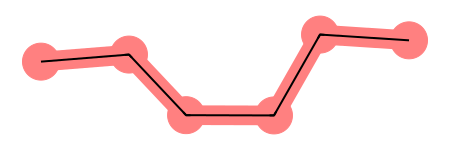

In [65]:
def assign_atom_types_by_smarts(mol, type_to_smarts):
    """
    Assigns:
    - atom.SetProp("main_type", main_type) using get_main_type()
    - atom.SetProp("label", label) based on SMARTS match and declared priority
    """
    compiled_smarts = load_smarts(type_to_smarts)
    
    # First pass: assign main_type to all atoms
    for atom in mol.GetAtoms():
        main_type = get_main_type(atom)
        if main_type in type_to_smarts:
            atom.SetProp("main_type", main_type)
    
    # Process atoms by main_type
    for main_type, patterns in compiled_smarts.items():
        atoms_of_type = [
            atom for atom in mol.GetAtoms()
            if atom.HasProp("main_type") and atom.GetProp("main_type") == main_type
        ]
        if not atoms_of_type:
            continue

        # Precompute all SMARTS matches for this type
        pattern_matches = {}
        for label, pattern in patterns.items():
            matches = mol.GetSubstructMatches(pattern)
            for match in matches:
                for atom_idx in match:
                    if atom_idx not in pattern_matches:
                        prev = pattern_matches.get(atom_idx, "")
                        if prev != "":
                            prev += "%%"
                        pattern_matches[atom_idx] = prev + label 

        # Assign labels
        for atom in atoms_of_type:
            idx = atom.GetIdx()
            if idx in pattern_matches:
                atom.SetProp("label", pattern_matches[idx])
            else:
                atom.SetProp("label", main_type)
                print("Warning: No corresponding pseudoatom type could be assigned to atom with index ", atom.GetIdx(), " and main type ", main_type)
        # print(pattern_matches)
    return mol

mol = get_mol("hexane")
mol = assign_atom_types_by_smarts(mol, type_to_smarts)

for atom in mol.GetAtoms():
    print(atom.GetProp("main_type"), "  ->  ", atom.GetProp("label"))

mol

In [66]:
a='''
print("Not covered: multiple overlapping functional groups")
mol = get_mol("1-hydroxy-hexan-2-one")
x = assign_atom_types_by_smarts(mol, type_to_smarts)
x.__sssAtoms=[6]
x.Compute2DCoords()

for atom in x.GetAtoms():
    print(atom.GetProp("main_type"), "  ->  ", atom.GetProp("label"))
x
'''

In [67]:
def bonded_definitions(stretches, bends, torsions, bonded):
    stretch_labels, _, _, bend_labels, _, torsion_labels, _ = bonded

    # Bond stretching parameters
    lines = []
    
    if len(stretches) > 0:
        lines.append("# Bond stretch: atom n1-n2, type, parameters")
        for atoms, bond_type in stretches.items():
            atom1, atom2 = atoms
            eq_length = list(stretch_labels[bond_type])[0]
            lines.append(f"{atom1} {atom2} {bond_type} 96500 {eq_length}")

    # Bond bending parameters
    if len(bends) > 0:
        lines.append("# Bond bending: atom n1-n2-n3, type, parameters")
        for atoms, bend_type in bends.items():
            atom1, atom2, atom3 = atoms 
            force_constant, theta = list(bend_labels[bend_type])[0]
            lines.append(f"{atom1} {atom2} {atom3} {bend_type} {force_constant} {theta}")

    # Torsion parameters
    if len(torsions) > 0:
        lines.append("# Torsion: atom n1-n2-n3-n4, type, parameters")
        for atoms, torsion_type in torsions.items():
            atom1, atom2, atom3, atom4 = atoms
            c0, c1, c2, c3 = list(torsion_labels[torsion_type])[0]
            lines.append(f"{atom1} {atom2} {atom3} {atom4} {torsion_type} {c0} {c1} {c2} {c3}")
    return"\n".join(lines)

In [68]:
def assign_torsion(atom_tuple, torsion_data, label="label"):
    a0, a1, a2, a3 = atom_tuple
    printed = None
    done = False    

    for l0 in a0.GetProp(label).split("%%"):    
        t0 = torsion_data.get(l0, None)
        if t0 is None:
            print("No torsion for atom ", l0)
            continue
        
        done2 = False
        for l1 in a1.GetProp(label).split("%%"):
            done3 = False
            for l2 in a2.GetProp(label).split("%%"):
                t1 = t0.get(l1, None)
                if t1 is None:
                    continue
                
                t2 = t1.get(l2, None)
                if t2 is None:
                    continue
                
                for l3 in a3.GetProp(label).split("%%"):    
                    t3 = t2.get(l3, None)
                    if t3 is None:
                        continue

                    # torsion of atoms a0 - a1 - a2 - a3

                    if a0 == a3:    # 3-ring has no torsions
                        continue

                    torsions[(a0.GetIdx(), a1.GetIdx(), a2.GetIdx(), a3.GetIdx())] = t3

                    done = True
                    done2 = True
                    done3 = True
                    break 
                if done3:
                    break
            if not done3 and printed is None:
                printed = "No torsion for atom "+ l0+ " <-> "+ l1 + " <-> "+ l2
            if done2:
                break
        if not done2 and printed is None:
            printed = "No torsion for atom " + l0 + " <-> " + l1
        if done:
            break
    return done, printed

In [69]:
def assign_bend(atom_tuple, bend_data, label="label"):
    n1, a, n2 = atom_tuple
    printed = None
    done = False

    for al in a.GetProp(label).split("%%"):
        bends_a = bend_data.get(al, None)
        if bends_a is None:
            continue

        done2 = False
        for n1l in n1.GetProp(label).split("%%"):
            bends_t = bends_a.get(n1l, None)
            if bends_t is None:
                continue

            done3 = False
            for n2l in n2.GetProp(label).split("%%"):
                if n1 == n2:
                    continue
                b = bends_t.get(n2l, None)
                if b is None:
                    continue
                bends[(n1.GetIdx(), a.GetIdx(), n2.GetIdx())] = b
                done = True
                done2 = True
                done3 = True
                break  # assigned, break n2l loop
            if not done3:
                printed = f"No bends known for atoms with type {a.GetProp(label)} and {n1.GetProp(label)} and {n2.GetProp(label)}"
            if done2:
                break  # assigned for this n1
        if not done2 and printed is None:
            printed = f"No bends known for atoms with type {a.GetProp(label)} and {n1.GetProp(label)}"
        if done:
            break  # assigned for this al
    if not done and printed is None:
        printed = f"No bends known for atom with type {a.GetProp(label)}"
    return done, printed


In [70]:
def assign_bonded_interactions(mol, bonded):
    _, _, stretches_atoms_bonds, _, bend_atoms, bends_main_atoms, _, torsion_atoms, torsion_main_atoms = bonded

    bonds = {}

    for bond in mol.GetBonds():
        done = False
        for a1 in bond.GetBeginAtom().GetProp("label").split("%%"):
            if done:
                break
            for a2 in bond.GetEndAtom().GetProp("label").split("%%"):
                label = stretches_atoms_bonds.get(a1, {}).get(a2, None)
                if label is not None:
                    bond.SetProp("label", label)
                    bonds[(bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx())] = label
                    done = True
                    break
        if not done:
            print("No bond label could be matched for ", bond.GetBeginAtom().GetProp("label"), " <-> ", bond.GetEndAtom().GetProp("label"))
    

    bends = {}

    for a in mol.GetAtoms():
        neighbors = a.GetNeighbors()
        if len(neighbors) < 2:
            continue

        # All unordered 3-atom bends: each pair of neighbors forms n1-a-n2
        for i, n1 in enumerate(neighbors):
            for j, n2 in enumerate(neighbors):
                if i == j:
                    continue  # skip same neighbor
                atom_tuple = (n1, a, n2)
                success, printed = assign_bend(atom_tuple, bend_atoms)
                if not success:
                    success_main, printed_main = assign_bend(atom_tuple, bends_main_atoms, label="main_type")
                    if success_main:
                        print("Using main type! ", printed)
                    else:
                        for msg in printed_main:
                            print(msg)



    torsions = {}

    for bond in mol.GetBonds():
        b_id = bond.GetIdx()
        a1 = bond.GetBeginAtom()
        a2 = bond.GetEndAtom()
        
        # find all pairs of neighboring bonds
        b1 = [b for b in a1.GetBonds() if b.GetIdx() != b_id]
        b2 = [b for b in a2.GetBonds() if b.GetIdx() != b_id]

        if len(b1) == 0 or len(b2) == 0:    # >= 1 atom is terminal
            continue

        for b0 in b1:
            a0 = [a for a in [b0.GetBeginAtom(), b0.GetEndAtom()] if a.GetIdx() != a1.GetIdx()][0]
            for b3 in b2:
                a3 = [a for a in [b3.GetBeginAtom(), b3.GetEndAtom()] if a.GetIdx() != a2.GetIdx()][0]
                
                if a0 == a3:    # skip 3-ring
                    continue

                atoms_tuple = (a0, a1, a2, a3)

                success, printed = assign_torsion(atoms_tuple, torsion_atoms)
                if not success:
                    success, printed_main = assign_torsion(atoms_tuple, torsion_main_atoms, label="main_type")
                    if success:
                        print("Using main type! ", printed)
                    else:
                        print(printed_main)
    return bonds, bends, torsions    

In [76]:
mol = get_mol("2-octanone")
mol = assign_atom_types_by_smarts(mol, type_to_smarts)
bonds, bends, torsions = assign_bonded_interactions(mol, bonded)
# print(bonded_definitions(bonds, bends, torsions, bonded))